<a href="https://colab.research.google.com/github/MalakGrami/Real-Estate-Price-Prediction/blob/main/Pr%C3%A9dictionDePrixImmobiliers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import PolynomialFeatures

# Define the columns to keep
columns_to_keep = [
    'Id', 'LotFrontage', 'LotArea', 'Neighborhood', 'YearBuilt', 'YearRemodAdd', 'OverallQual',
    'OverallCond', 'MasVnrType', 'ExterQual', 'BsmtQual', 'BsmtFinType1', 'BsmtFinSF1',
    'BsmtFinType2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
    'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
    'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageFinish',
    'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch',
    'PoolArea'
]

# URLs de téléchargement direct
data_url = "https://drive.google.com/uc?export=download&id=1SMI4xiOfnU52M3f_Efpit9lTDgCNbzt3"
data2_url = "https://drive.google.com/uc?export=download&id=1c-Ep1kNnvwTTGMCM1aRG5-lwTsaCYr8u"

# Lire les fichiers CSV depuis Google Drive
data = pd.read_csv(data_url)
data2 = pd.read_csv(data2_url)

# Sélectionner les colonnes souhaitées de data.csv
data_cleaned = data[columns_to_keep]

# Vérifier si le champ SalePrice existe dans data2.csv
if 'SalePrice' in data2.columns:
    # Fusionner les DataFrames en fonction d'une colonne commune (si elle existe)
    merged_data = data_cleaned.merge(data2[['SalePrice', 'Id']], how='left', on='Id')
    # Supprimer la colonne 'Id' du DataFrame fusionné
    merged_data = merged_data.drop(columns=['Id'])
else:
    print("Error: SalePrice column not found in data2.csv")
    # Gérer le cas où SalePrice est manquant (optionnel)

# Afficher les premières lignes des données fusionnées
print(merged_data.head())



   LotFrontage  LotArea Neighborhood  YearBuilt  YearRemodAdd  OverallQual  \
0         80.0    11622        NAmes       1961          1961            5   
1         81.0    14267        NAmes       1958          1958            6   
2         74.0    13830      Gilbert       1997          1998            5   
3         78.0     9978      Gilbert       1998          1998            6   
4         43.0     5005      StoneBr       1992          1992            8   

   OverallCond MasVnrType ExterQual BsmtQual  ... GarageYrBlt  GarageFinish  \
0            6        NaN        TA       TA  ...      1961.0           Unf   
1            6    BrkFace        TA       TA  ...      1958.0           Unf   
2            5        NaN        TA       Gd  ...      1997.0           Fin   
3            6    BrkFace        TA       TA  ...      1998.0           Fin   
4            5        NaN        Gd       Gd  ...      1992.0           RFn   

  GarageCars  GarageArea  WoodDeckSF  OpenPorchSF  Enclo

In [ ]:
def clean_data(data):
    # Supprimer les doublons
    data = data.drop_duplicates()

    # Supprimer les lignes avec des valeurs NaN
    cleaned_data = data.dropna()


    return cleaned_data

# Nettoyer les données
cleaned_data = clean_data(merged_data)
# print(cleaned_data.to_string());


def encoder_donnees_categorielles(data):
    # Colonnes nominales et ordinales
    colonnes_categoriques = {
        'Neighborhood': ['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor', 'Edwards',
                         'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel', 'NAmes', 'NoRidge', 'NPkVill', 'NridgHt',
                         'NWAmes', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber',
                         'Veenker'],
        'MasVnrType': ['BrkCmn', 'BrkFace', 'CBlock', 'None', 'Stone'],
        'GarageType': ['2Types', 'Attchd', 'Basment', 'BuiltIn', 'CarPort', 'Detchd', 'None'],
        'ExterQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
        'BsmtQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
        'BsmtFinType1': ['Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
        'BsmtFinType2': ['Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
        'KitchenQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
        'GarageFinish': ['Unf', 'RFn', 'Fin']
    }

    # Vérification et encodage ordinal pour les colonnes catégoriques
    cols_to_encode = [col for col in colonnes_categoriques.keys() if col in data.columns]
    if cols_to_encode:
        enc_ordinal = OrdinalEncoder(categories=[colonnes_categoriques[col] for col in cols_to_encode])
        data[cols_to_encode] = enc_ordinal.fit_transform(data[cols_to_encode])
    else:
        print("Avertissement : aucune des colonnes catégoriques n'est présente dans les données.")

    # S'assurer que toutes les colonnes numériques sont du bon type de données
    colonnes_numeriques = ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'OverallQual',
                           'OverallCond', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
                           'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
                           'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars',
                           'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch',
                           'PoolArea', 'SalePrice']

    for col in colonnes_numeriques:
        if col in data.columns:
            data[col] = data[col].astype(float)
        else:
            print(f"Avertissement : la colonne {col} n'est pas présente dans les données.")

    return data

# Appliquer la fonction à vos données nettoyées
donnees_encodees = encoder_donnees_categorielles(cleaned_data)
print(donnees_encodees.to_string())



      LotFrontage  LotArea  Neighborhood  YearBuilt  YearRemodAdd  OverallQual  OverallCond  MasVnrType  ExterQual  BsmtQual  BsmtFinType1  BsmtFinSF1  BsmtFinType2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  2ndFlrSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  KitchenQual  TotRmsAbvGrd  Fireplaces  GarageType  GarageYrBlt  GarageFinish  GarageCars  GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  ScreenPorch  PoolArea      SalePrice
1            81.0  14267.0          12.0     1958.0        1958.0          6.0          6.0         1.0        2.0       2.0           4.0       923.0           0.0      406.0       1329.0    1329.0       0.0     1329.0           0.0           0.0       1.0       1.0           3.0           1.0          3.0           6.0         0.0         1.0       1958.0           0.0         1.0       312.0       393.0         36.0            0.0          0.0       0.0  187758.393989
3            78.0   9978.0           8.0     199

Mean Squared Error: 173395352.89
R-squared: 0.14


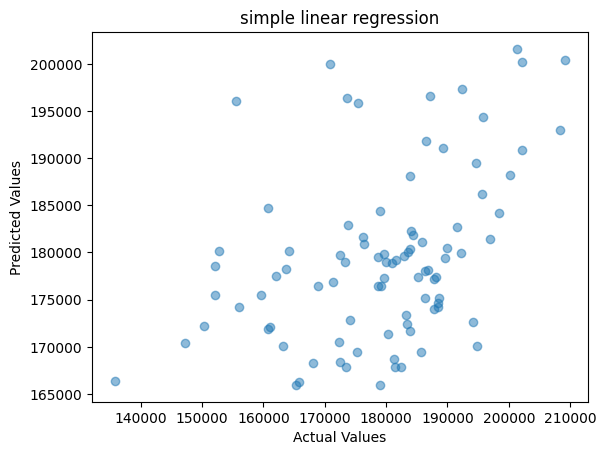

In [ ]:

# Selecting the feature and target variable
X = donnees_encodees[['GrLivArea']]  # Predictor variable
y = donnees_encodees['SalePrice']     # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

# Compare actual vs predicted values
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('simple linear regression')
plt.show()


Mean Squared Error: 17537222.62
R-squared: 0.91


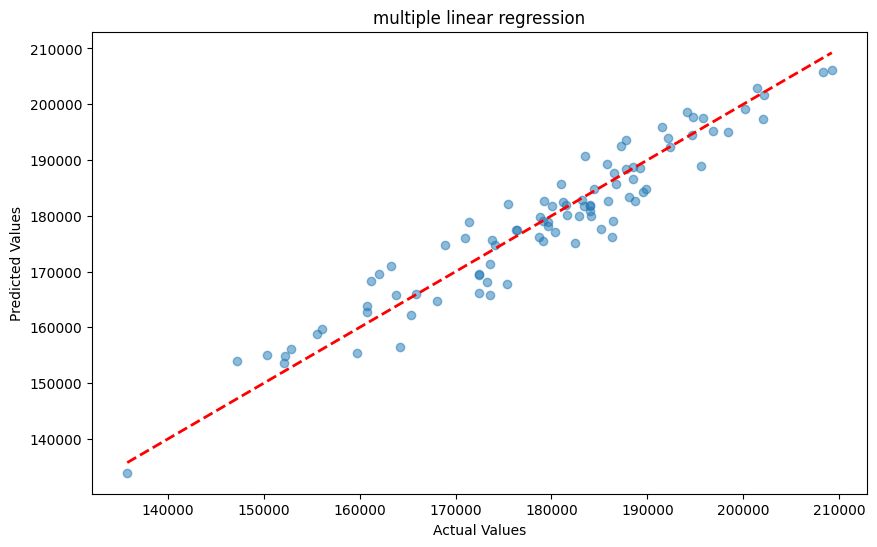

In [ ]:
X = donnees_encodees.drop(columns=['SalePrice'])  # Assuming X contains multiple features
y = donnees_encodees['SalePrice']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the multiple linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

# Compare actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('multiple linear regression')
plt.show()

Mean Squared Error (Polynomial Regression): 23685432450.94
R-squared (Polynomial Regression): -117.00


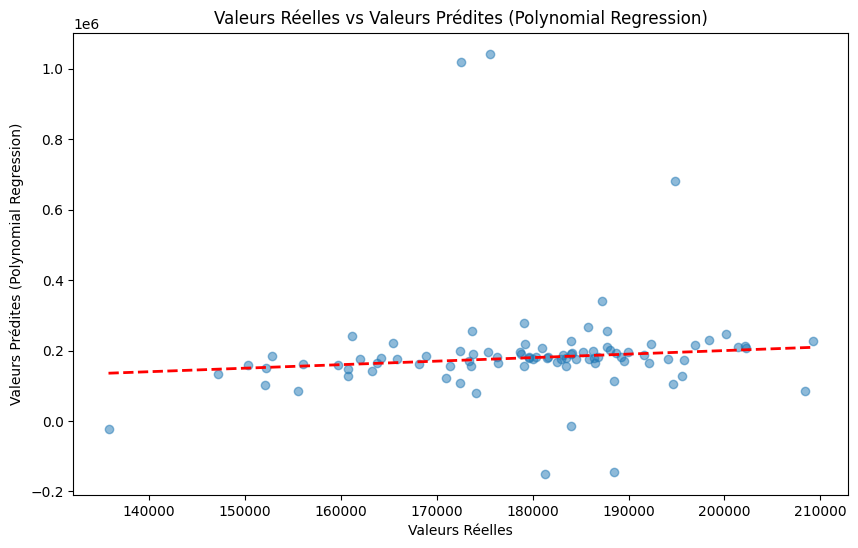

In [ ]:

# Define the degree of the polynomial features
degree = 2
# Create polynomial features
poly_features = PolynomialFeatures(degree=degree)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

# Create and train the polynomial regression model
model_poly = LinearRegression()
model_poly.fit(X_train_poly, y_train)

# Make predictions on the test set
y_pred_poly = model_poly.predict(X_test_poly)

# Calculate metrics for polynomial regression
mse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)

print(f"Mean Squared Error (Polynomial Regression): {mse_poly:.2f}")
print(f"R-squared (Polynomial Regression): {r2_poly:.2f}")

# Plotting the results for polynomial regression
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_poly, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valeurs Réelles')
plt.ylabel('Valeurs Prédites (Polynomial Regression)')
plt.title('Valeurs Réelles vs Valeurs Prédites (Polynomial Regression)')
plt.show()


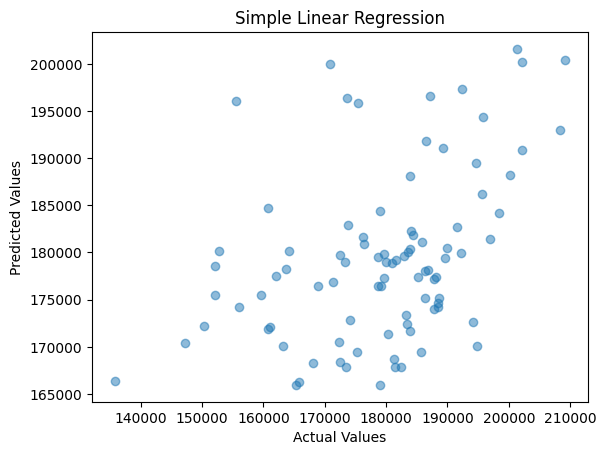

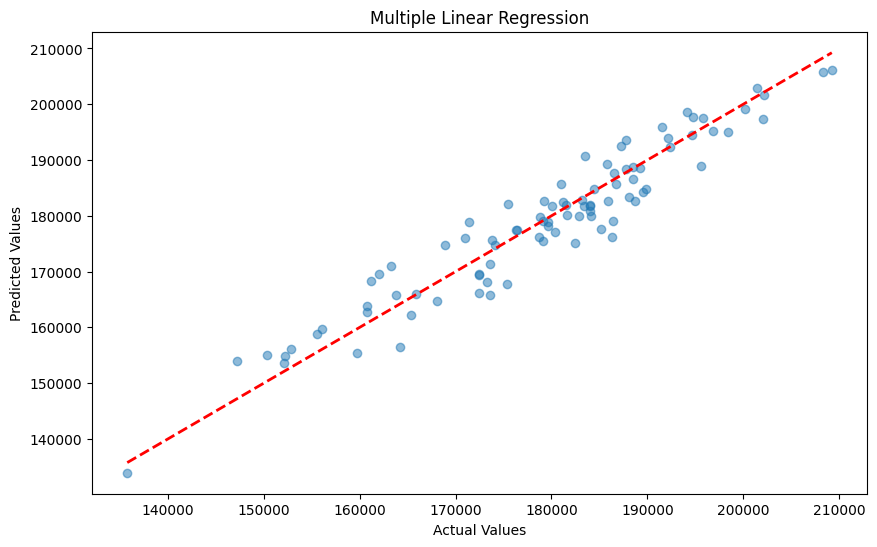

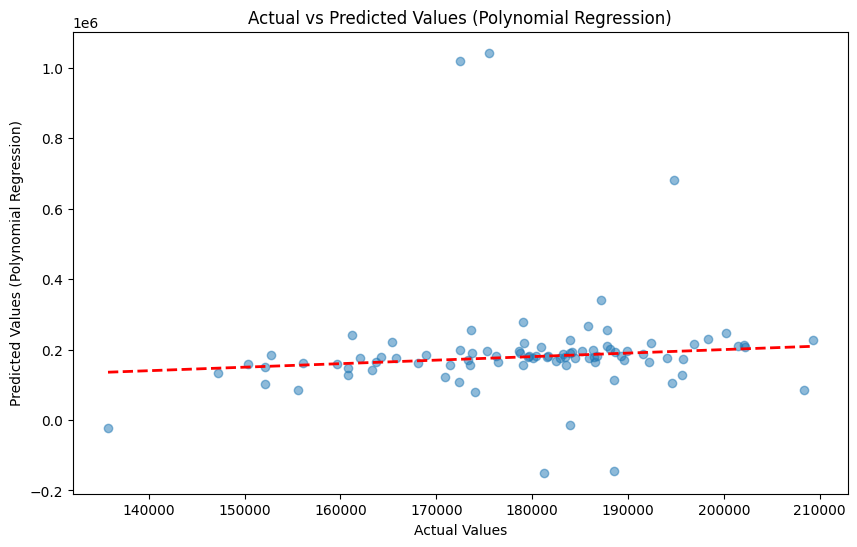

RMSE for Simple Linear Regression: 13167.966923146503
RMSE for Multiple Linear Regression: 4187.746723847771
RMSE for Polynomial Regression: 153900.72271090146
Percentage Improvement/Decrement for Simple Linear Regression: 214.44038504428838 %
Percentage Improvement/Decrement for Multiple Linear Regression: 0.0 %
Percentage Improvement/Decrement for Polynomial Regression: 3575.0246101200437 %


In [ ]:
def simple_linear_regression(X, y):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create and train the simple linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    # Compare actual vs predicted values
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Simple Linear Regression')
    plt.show()

    return rmse, y_test, y_pred

def multiple_linear_regression(X, y):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create and train the multiple linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    # Compare actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Multiple Linear Regression')
    plt.show()

    return rmse, y_test, y_pred

def polynomial_regression(X_train, X_test, y_train, y_test, degree=2):
    # Create polynomial features
    poly_features = PolynomialFeatures(degree=degree)
    X_train_poly = poly_features.fit_transform(X_train)
    X_test_poly = poly_features.transform(X_test)

    # Create and train the polynomial regression model
    model_poly = LinearRegression()
    model_poly.fit(X_train_poly, y_train)

    # Make predictions on the test set
    y_pred_poly = model_poly.predict(X_test_poly)

    # Calculate metrics for polynomial regression
    mse_poly = mean_squared_error(y_test, y_pred_poly)
    rmse_poly = np.sqrt(mse_poly)

    # Plotting the results for polynomial regression
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred_poly, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values (Polynomial Regression)')
    plt.title('Actual vs Predicted Values (Polynomial Regression)')
    plt.show()

    return rmse_poly, y_test, y_pred_poly

# Selecting the feature and target variable
X_simple = donnees_encodees[['GrLivArea']]  # Predictor variable
y_simple = donnees_encodees['SalePrice']     # Target variable

X_multiple = donnees_encodees.drop(columns=['SalePrice'])  # Assuming X contains multiple features
y_multiple = donnees_encodees['SalePrice']

# Define the degree of the polynomial features
degree = 2

# Split the data into training and testing sets for polynomial regression
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_multiple, y_multiple, test_size=0.2, random_state=42)

# Perform each type of regression and calculate RMSE
rmse_simple, y_test_simple, y_pred_simple = simple_linear_regression(X_simple, y_simple)
rmse_multiple, y_test_multiple, y_pred_multiple = multiple_linear_regression(X_multiple, y_multiple)
rmse_poly, y_test_poly, y_pred_poly = polynomial_regression(X_train_poly, X_test_poly, y_train_poly, y_test_poly, degree)

# Print the results
print("RMSE for Simple Linear Regression:", rmse_simple)
print("RMSE for Multiple Linear Regression:", rmse_multiple)
print("RMSE for Polynomial Regression:", rmse_poly)


# Calculate the percentage improvement/degradation for each algorithm
percentage_improvement_simple = ((rmse_simple - min(rmse_simple, rmse_multiple, rmse_poly)) / min(rmse_simple, rmse_multiple, rmse_poly)) * 100
percentage_improvement_multiple = ((rmse_multiple - min(rmse_simple, rmse_multiple, rmse_poly)) / min(rmse_simple, rmse_multiple, rmse_poly)) * 100
percentage_improvement_poly = ((rmse_poly - min(rmse_simple, rmse_multiple, rmse_poly)) / min(rmse_simple, rmse_multiple, rmse_poly)) * 100

# Print the percentage improvement/degradation for each algorithm
print("Percentage Improvement/Decrement for Simple Linear Regression:", percentage_improvement_simple, "%")
print("Percentage Improvement/Decrement for Multiple Linear Regression:", percentage_improvement_multiple, "%")
print("Percentage Improvement/Decrement for Polynomial Regression:", percentage_improvement_poly, "%")
